In [1]:
import xarray as xr
import pathlib
import sys
import datetime
from data_config import (
    get_scratch_dir,
    get_dask_log_dir,
    get_dask_local_dir,
)

from process_files import (
    memory,
    get_case_metadata,
)
import numpy as np

import pandas as pd
import tqdm
import dask.array as da
import numcodecs

In [2]:
scratch = get_scratch_dir()
dask_log_directory = get_dask_log_dir()
dask_local_directory = get_dask_local_dir()

In [3]:
parent_dir = pathlib.Path.cwd().parent
sys.path.append(str(parent_dir))

In [4]:
import atlas

In [5]:
@memory.cache
def get_done_cases_df(today=datetime.datetime.today().date()):
    calc = atlas.global_irf_map(cdr_forcing="DOR", vintage="001")

    data = calc.df
    # done = data.loc[data.archive]
    done = data

    done_cases = done.index.to_list()
    done_cases.remove("smyle.cdr-atlas-v0.control.001")
    done_cases = sorted(done_cases)

    df = calc.df.loc[done_cases]
    return df, done_cases

In [6]:
%%time

df, done_cases = get_done_cases_df()
df

CPU times: user 6.05 ms, sys: 4.55 ms, total: 10.6 ms
Wall time: 13.7 ms


,blueprint,polygon,polygon_master,basin,start_date,cdr_forcing,cdr_forcing_file,simulation_key,refdate,stop_n,wallclock,curtail_output
case,,,,,,,,,,,,
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001,smyle,0.0,0.0,North_Atlantic_basin,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-01-01_00000,0347-01-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-04-01_00001.001,smyle,0.0,0.0,North_Atlantic_basin,1999-04,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-04-01_00001,0347-04-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-07-01_00002.001,smyle,0.0,0.0,North_Atlantic_basin,1999-07,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-07-01_00002,0347-07-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-10-01_00003.001,smyle,0.0,0.0,North_Atlantic_basin,1999-10,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-10-01_00003,0347-10-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_001_1999-01-01_00004.001,smyle,1.0,1.0,North_Atlantic_basin,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_001_1999-01-01_00004,0347-01-01,15,10:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...
smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_038_1999-10-01_02755.001,smyle,38.0,688.0,Southern_Ocean,1999-10,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_Southern_Ocean_038_1999-10-01_02755,0347-10-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_039_1999-01-01_02756.001,smyle,39.0,689.0,Southern_Ocean,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_Southern_Ocean_039_1999-01-01_02756,0347-01-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_039_1999-04-01_02757.001,smyle,39.0,689.0,Southern_Ocean,1999-04,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_Southern_Ocean_039_1999-04-01_02757,0347-04-01,15,10:00:00,True


In [7]:
base_directory = pathlib.Path(
    "/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/analysis"
)
base_directory

PosixPath('/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/analysis')

In [8]:
def add_additional_coords(ds: xr.Dataset, case: str, case_metadata: pd.Series):
    polygon_master = int(case_metadata.polygon_master)
    if polygon_master < 0 or polygon_master > 689:
        raise ValueError(
            f"Polygon id must be in range [0, 690). Found polygon_id={polygon_master}"
        )

    # add as an integer coordinate
    polygon_id_coord = xr.DataArray(
        name="polygon_id",
        dims="polygon_id",
        data=[polygon_master],
        attrs={"long_name": "polygon ID"},
    ).astype("int32")

    # injenction date
    injection_date_coord = xr.DataArray(
        data=[int(case_metadata.start_date.split("-")[-1])],
        dims=["injection_date"],
        attrs={"long_name": "injection date", "units": "month of 1999"},
    ).astype("int32")

    renamed = ds.drop_vars("time").rename_dims(time="elapsed_time")

    return renamed.assign_coords(
        polygon_id=polygon_id_coord,
        injection_date=injection_date_coord,
    )


def expand_ensemble_dims(ds: xr.Dataset) -> xr.Dataset:
    """Add new dimensions across the ensemble"""

    copied = ds.copy()

    # all data variables should be ensemble variables
    for name in list(ds.data_vars):
        copied[name] = copied[name].expand_dims(["polygon_id", "injection_date"])

    # absolute time is a function of injection_date because of the different starting times
    # copied["time"] = copied["time"].expand_dims(["injection_date"])
    # copied["time_bound"] = copied["time_bound"].expand_dims(["injection_date"])

    return copied


def compute_dor_efficiency(ds: xr.Dataset) -> xr.Dataset:
    ds["DOR_efficiency"] = (-ds.DIC_ADD_TOTAL / ds.DIC_FLUX).astype("float32")
    return ds


def set_compression_encoding(ds: xr.Dataset) -> xr.Dataset:
    compressor = numcodecs.Zlib(level=1)

    for name, var in ds.variables.items():
        # avoid using NaN as a fill value, and avoid overflow errors in encoding
        if np.issubdtype(var.dtype, np.integer):
            ds[name].encoding = {"compressor": compressor, "_FillValue": 2_147_483_647}
        elif var.dtype == np.dtype("float32"):
            ds[name].encoding = {
                "compressor": compressor,
                "_FillValue": 9.969209968386869e36,
            }
        else:
            ds[name].encoding = {"compressor": compressor}

    return ds


def set_elapsed_time(ds: xr.Dataset):
    elapsed_time_integer_months = xr.DataArray(
        np.arange(180), dims=["elapsed_time"], attrs={"units": "months"}
    )
    ds["elapsed_time"] = elapsed_time_integer_months.astype("int32")
    return ds


def process_case(case: str, df: pd.DataFrame) -> xr.Dataset:
    case_metadata = get_case_metadata(case, df=df)
    path = base_directory / f"{case}.analysis.zarr"
    if not path.exists():
        return None
    ds = (
        xr.open_dataset(path, engine="zarr", chunks={}, decode_timedelta=True)
        .pipe(add_additional_coords, case, case_metadata)
        .pipe(expand_ensemble_dims)
        .pipe(compute_dor_efficiency)
        .pipe(set_elapsed_time)
    )
    return ds[["DOR_efficiency", "elapsed_time"]].drop_vars(["time_delta"])


def process_case_without_data(
    case: str, df: pd.DataFrame, ds: xr.Dataset
) -> xr.Dataset:
    case_metadata = get_case_metadata(case, df=df)
    original_attrs = ds.polygon_id.attrs
    ds = ds.assign_coords(polygon_id=[case_metadata.polygon_master])
    ds["polygon_id"] = ds["polygon_id"].astype("int32")
    ds["polygon_id"].attrs = original_attrs

    return ds

In [9]:
def create_empty_target_store():
    store1b_chunks_encoding_per_variable = {
        "DOR_efficiency": {
            "chunks": {"polygon_id": 1, "injection_date": 1, "elapsed_time": 180}
        },  # polygon_id: 1 injection_date: 1 elapsed_time: 180
        "polygon_id": {"chunks": {"polygon_id": 690}},  # polygon_id: 1
        "injection_date": {"chunks": {"injection_date": 1}},  # injection_date: 1
        "elapsed_time": {"chunks": {"elapsed_time": 180}},  # elapsed_time: 180
    }
    sizes_all_dims = {
        "elapsed_time": 180,
        "polygon_id": 690,
        "injection_date": 4,
    }

    placeholder = xr.Dataset()
    placeholder["elapsed_time"] = xr.DataArray(
        np.arange(180), dims=["elapsed_time"], attrs={"units": "months"}
    )
    placeholder["polygon_id"] = xr.DataArray(
        np.arange(690),
        dims=["polygon_id"],
        attrs={"long_name": "Polygon ID"},
    )
    placeholder["injection_date"] = xr.DataArray(
        np.array([1, 4, 7, 10]),
        dims=["injection_date"],
        attrs={"long_name": "injection date", "units": "month of 1999"},
    )

    var_chunks = store1b_chunks_encoding_per_variable["DOR_efficiency"]["chunks"]
    var_dims = list(var_chunks.keys())
    var_sizes = {d: s for d, s in sizes_all_dims.items() if d in var_dims}
    var_shape = tuple(var_sizes.values())
    ordered_var_dims = list(var_sizes.keys())

    placeholder["DOR_efficiency"] = xr.DataArray(
        da.empty(
            shape=var_shape,
            chunks=var_chunks,
            dtype="float32",
        ),
        dims=ordered_var_dims,
    )
    placeholder = (
        placeholder.pipe(set_compression_encoding)
        .chunk(polygon_id=-1, injection_date=1, elapsed_time=-1)
        .transpose("elapsed_time", "polygon_id", "injection_date")
    )

    return placeholder

In [10]:
store_path = "s3://carbonplan-dor-efficiency/store1b.zarr"

placeholder = create_empty_target_store()
placeholder

<xarray.Dataset> Size: 2MB
Dimensions:         (elapsed_time: 180, polygon_id: 690, injection_date: 4)
Coordinates:
  * elapsed_time    (elapsed_time) int64 1kB 0 1 2 3 4 5 ... 175 176 177 178 179
  * polygon_id      (polygon_id) int64 6kB 0 1 2 3 4 5 ... 685 686 687 688 689
  * injection_date  (injection_date) int64 32B 1 4 7 10
Data variables:
    DOR_efficiency  (elapsed_time, polygon_id, injection_date) float32 2MB dask.array<chunksize=(180, 690, 1), meta=np.ndarray>

In [11]:
placeholder.to_zarr(
    store_path, consolidated=True, zarr_format=2, mode="w", compute=False
)

Delayed('_finalize_store-b68e4802-5ad0-464c-b50d-f024f4cc2967')

In [12]:
%%time

for key, group in df.groupby("start_date"):
    cases_without_data = []
    dsets = []
    for case in tqdm.tqdm(group.index):
        single_ds = process_case(case=case, df=group)
        if single_ds:
            dsets.append(single_ds)
        else:
            cases_without_data.append(case)

    for case in cases_without_data:
        single_ds = xr.zeros_like(dsets[0])
        single_ds = process_case_without_data(case=case, df=group, ds=single_ds)
        dsets.append(single_ds)
    dataset = (
        xr.combine_by_coords(dsets, combine_attrs="drop_conflicts")
        .transpose("elapsed_time", "polygon_id", ...)
        .chunk(polygon_id=-1, elapsed_time=-1)
    )
    dataset.to_zarr(store_path, region="auto")

    print(f"Number of cases without data for group={key}: {len(cases_without_data)}")

100%|██████████| 690/690 [00:25<00:00, 27.56it/s]


Number of cases without data for group=1999-01: 0


100%|██████████| 690/690 [00:23<00:00, 29.88it/s]


Number of cases without data for group=1999-04: 0


100%|██████████| 690/690 [00:21<00:00, 31.48it/s]


Number of cases without data for group=1999-07: 0


100%|██████████| 690/690 [00:21<00:00, 32.34it/s]


Number of cases without data for group=1999-10: 0
CPU times: user 1min 39s, sys: 6.78 s, total: 1min 45s
Wall time: 1min 47s


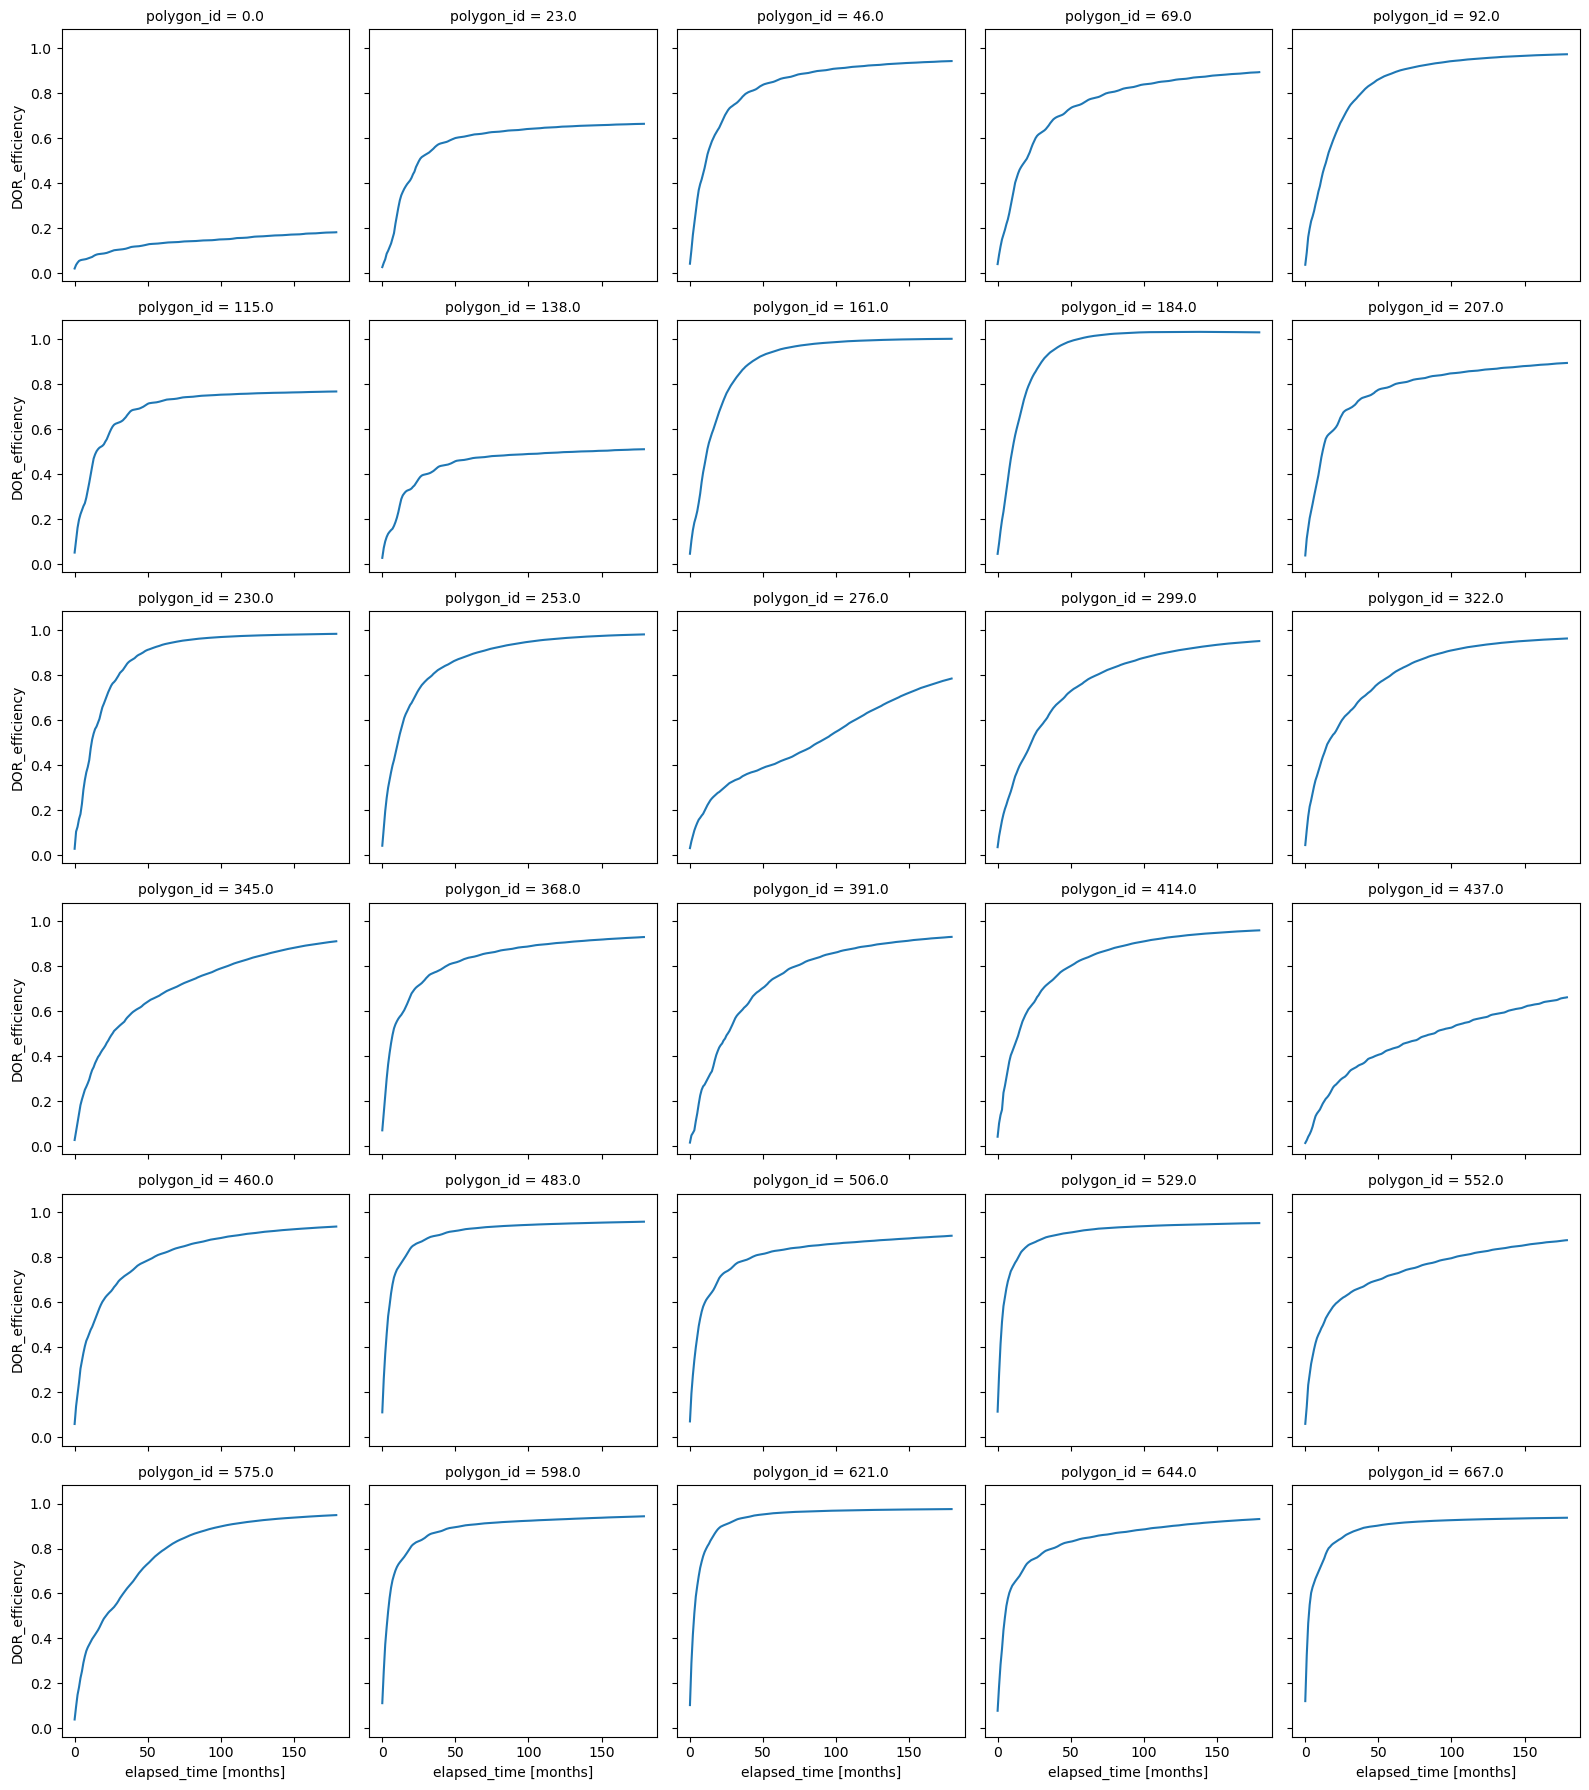

In [13]:
ds = xr.open_dataset(store_path, engine="zarr", chunks={})
# ds.sel(polygon_id=0).DOR_efficiency.plot(col_wrap=4, col="injection_date")
ds.isel(polygon_id=slice(0, 690, 23), injection_date=0).DOR_efficiency.plot(
    col_wrap=5, col="polygon_id"
)

In [14]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:         (elapsed_time: 180, polygon_id: 690, injection_date: 4)
Coordinates:
  * elapsed_time    (elapsed_time) float64 1kB 0.0 1.0 2.0 ... 177.0 178.0 179.0
  * injection_date  (injection_date) float64 32B 1.0 4.0 7.0 10.0
  * polygon_id      (polygon_id) float64 6kB 0.0 1.0 2.0 ... 687.0 688.0 689.0
Data variables:
    DOR_efficiency  (elapsed_time, polygon_id, injection_date) float32 2MB dask.array<chunksize=(180, 690, 1), meta=np.ndarray>

In [15]:
dset = xr.open_dataset(
    "https://carbonplan-oae-efficiency.s3.us-west-2.amazonaws.com/v2/store1b_rechunked.zarr/",
    engine="zarr",
    chunks={},
)
dset

<xarray.Dataset> Size: 3MB
Dimensions:         (elapsed_time: 180, polygon_id: 690, injection_date: 4,
                     nlat: 384, nlon: 320)
Coordinates:
    TAREA           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz              float32 4B ...
  * elapsed_time    (elapsed_time) float64 1kB 0.0 1.0 2.0 ... 177.0 178.0 179.0
  * injection_date  (injection_date) float64 32B 1.0 4.0 7.0 10.0
  * polygon_id      (polygon_id) float64 6kB 0.0 1.0 2.0 ... 687.0 688.0 689.0
Dimensions without coordinates: nlat, nlon
Data variables:
    OAE_efficiency  (elapsed_time, polygon_id, injection_date) float32 2MB dask.array<chunksize=(180, 690, 1), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    time_period_freq:  month_1
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...

In [16]:
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:48:41) [GCC 13.3.0]
python-bits: 64
OS: Linux
OS-release: 5.14.21-150500.55.65_13.0.73-cray_shasta_c
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: ('en_US', 'UTF-8')
libhdf5: 1.14.4
libnetcdf: 4.9.2

xarray: 2025.3.0
pandas: 2.2.2
numpy: 2.0.2
scipy: 1.15.1
netCDF4: 1.7.2
pydap: None
h5netcdf: None
h5py: None
zarr: 3.0.5
cftime: 1.6.4
nc_time_axis: None
iris: None
bottleneck: None
dask: 2025.2.0
distributed: 2025.2.0
matplotlib: 3.10.1
cartopy: None
seaborn: None
numbagg: None
fsspec: 2025.3.0
cupy: None
pint: None
sparse: 0.15.5
flox: None
numpy_groupies: None
setuptools: 75.8.0
pip: 25.0.1
conda: None
pytest: None
mypy: None
IPython: 8.17.2
sphinx: None
